Steg 1:
Det vi har börjat med är att vi har importerat CSV-filen i VS Code och sedan läst in filen med pandas.read_csv och eftersom filen är semikolon sepererad så har vi använt sep=";" Vi kan se att det finns 10 000 rader i varje kolumn, 10 kolumner och inga nollvärden etc. (Vi får finslipa texterna, detta är bara liten start)

In [12]:
import pandas as pd
df = pd.read_csv("car_price_dataset.csv", sep=";")
print(df.head()) #visar de första raderna i datan
print(df.shape)  #kollar storlek på rader och kolumner
print(df.info()) # kontrollerar kolumner och datatyper

        Brand   Model  Year  Engine_Size Fuel_Type    Transmission  Mileage  \
0         Kia     Rio  2020          4.2    Diesel          Manual   289944   
1   Chevrolet  Malibu  2012          2.0    Hybrid       Automatic     5356   
2    Mercedes     GLA  2020          4.2    Diesel       Automatic   231440   
3        Audi      Q5  2023          2.0  Electric          Manual   160971   
4  Volkswagen    Golf  2003          2.6    Hybrid  Semi-Automatic   286618   

   Doors  Owner_Count  Price  
0      3            5   8501  
1      2            3  12092  
2      4            2  11171  
3      2            1  11780  
4      3            3   2867  
(10000, 10)
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  str    
 1   Model         10000 non-null  str    
 2   Year          10000 non-null  int64  
 3   Engine_Siz

Här har vi visualiserat de genomsnittliga bilpriserna per årsmodell och utifrån detta känns vår data väldigt realistisk, desto nyare modell desto mer kostar bilen, det finns inga större avvikelser som t.ex att de äldre modellerna skulle vara dyrare, isåfall hade man kunnat tolka att bilarna i vår data är samlarobjekt men utifrån detta kan vi se att datan sannolikt är från ett konsumtions ändamål.

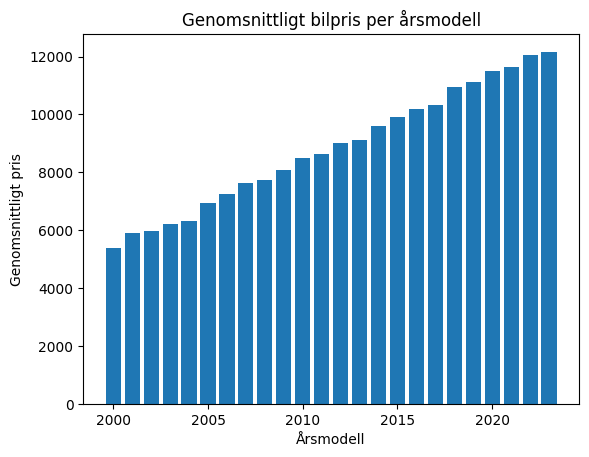

In [13]:
import matplotlib.pyplot as plt

avg_price_per_year = df.groupby("Year")["Price"].mean()

plt.figure()
plt.bar(avg_price_per_year.index, avg_price_per_year.values)
plt.xlabel("Årsmodell")
plt.ylabel("Genomsnittligt pris")
plt.title("Genomsnittligt bilpris per årsmodell")
plt.show()

Steg 2: För att lyckas förutsäga bilpriserna har vi valt att dela upp datan i tränings, validering och testdata, uppdelningen är 60% träning, 20% validering och 20% test.

In [19]:
# Delar upp i X och y
X = df.drop("Price", axis=1)
y = df["Price"]

# Delar upp i (hel)tränings- och 20% testset
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Delar upp träningsset i 20 % tränings- och 20% valideringsset
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42)


# Skapa en EDA-dataframe 
EDA_train_df = X_train_full.copy()
EDA_train_df["Price"] = y_train_full

print(EDA_train_df.head()) #visar de första raderna i datan
print(EDA_train_df.shape)  #kollar storlek på rader och kolumner
print(EDA_train_df.info()) # kontrollerar kolumner och datatyper

           Brand     Model  Year  Engine_Size Fuel_Type    Transmission  \
9254  Volkswagen      Golf  2007          3.2    Hybrid  Semi-Automatic   
1561         BMW  5 Series  2010          4.8  Electric  Semi-Automatic   
1670     Hyundai    Sonata  2006          1.9    Hybrid  Semi-Automatic   
6087       Honda      CR-V  2019          1.7    Diesel  Semi-Automatic   
6669    Mercedes   E-Class  2005          3.6    Petrol       Automatic   

      Mileage  Doors  Owner_Count  Price  
9254    33948      5            4   9721  
1561   224853      2            1   9402  
1670    13435      3            5   8531  
6087   199846      2            3   7503  
6669      261      3            2  10694  
(8000, 10)
<class 'pandas.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         8000 non-null   str    
 1   Model         8000 non-null   str    
 2   Year     

Denna visualiseringen visar bilpriser i förhållande till körsträcka och vad vi kan se är att desto längre körsträcka desto lägre värde har bilen, det finns några avikelser men inte så pass stora att vår data behövs justeras efter detta.

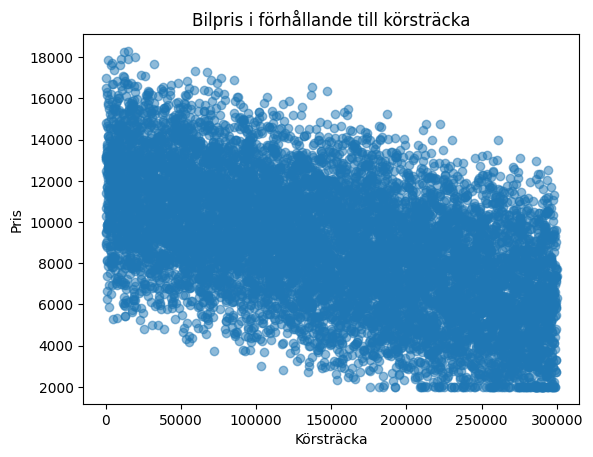

In [15]:
plt.figure()
plt.scatter(df["Mileage"], df["Price"], alpha=0.5)
plt.xlabel("Körsträcka")
plt.ylabel("Pris")
plt.title("Bilpris i förhållande till körsträcka")
plt.show()

Denna visualiseringen visar fördelningen av bilpriser och vad vi kan se så är genomsnittspriset för en bil ungefär 8 500 och det finns runt 650 bilar till detta pris, den dyraste bilen kostar runt 18 000 men finns väldigt få bilar till detta pris. Detta är en del av våran EDA för att se så att datan känns realistisk och inte innehåller förstora avvikelser som hade påverkat trovärdigheten av våran analys negativt.

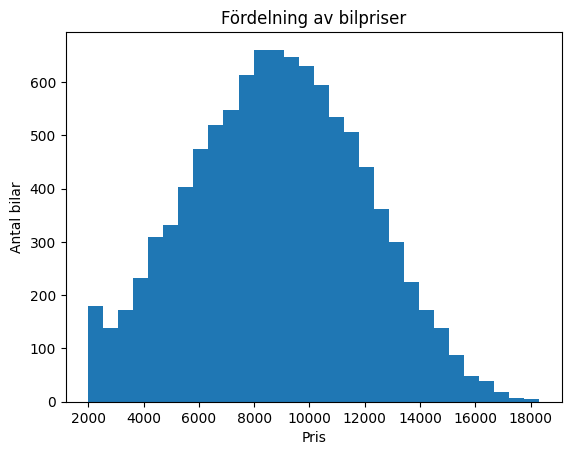

In [16]:
plt.figure()
plt.hist(df["Price"], bins=30)
plt.xlabel("Pris")
plt.ylabel("Antal bilar")
plt.title("Fördelning av bilpriser")
plt.show()


Innan modellen tränas förbehandlas datan för att kunna användas i maskininlärningsmodeller. Numeriska variabler hanteras genom att saknade värden ersätts med medianvärdet, medan kategoriska variabler omvandlas till numeriska värden med hjälp av One-Hot Encoding. Förbehandlingen anpassas endast på träningsdatan och appliceras därefter på validerings- och testdata för att undvika dataläckage.

Kategoriska variabler omvandlas till numeriska representationer med hjälp av One-Hot Encoding, där varje kategori kodas som en binär variabel. För att modellen ska kunna hantera kategorier som eventuellt endast förekommer i validerings- eller testdatan används inställningen handle_unknown="ignore".

Dessa förbehandlingssteg kombineras med hjälp av en ColumnTransformer, vilket möjliggör att olika transformationer appliceras på olika typer av variabler inom samma pipeline. Förbehandlingen anpassas (fit) endast på träningsdatan och appliceras därefter på validerings- och testdatan, vilket säkerställer att ingen information från framtida data läcker in i träningsprocessen. Slutligen resulterar förbehandlingen i en numerisk funktionsmatris som kan användas direkt av modellen.

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns #Numeriska kolumner
categorical_cols = X_train.select_dtypes(include=["object", "str"]).columns #Kategoriska kolumner

numerical_transformer = SimpleImputer(strategy="median") #Fyller saknade numeriska värden
categorical_transformer = OneHotEncoder(handle_unknown="ignore") #One-Hot Encoding av kategorier

preprocessor = ColumnTransformer([ #Kombinerar förbehandling
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

X_train_processed = preprocessor.fit_transform(X_train) #Fit + transform på train
X_val_processed = preprocessor.transform(X_val) #Transform på val
X_test_processed = preprocessor.transform(X_test) #Transform på test

X_train_processed.shape #Kontrollerar dimensioner


(6000, 52)